## **Sentiment Analysis Using MLP Classifier**

## **Load Libraries and Dataset**

In [1]:
pip install Sastrawi

Note: you may need to restart the kernel to use updated packages.


In [2]:
## MLP Classifier

import pandas as pd
import numpy as np
import nltk
import regex as re
import pickle
from nltk.corpus import stopwords as stopword
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/bianda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bianda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
data_df = pd.read_csv('train_preprocess.tsv.txt', names = ['Text','Sentiment'], sep = '\t')
data_df.drop_duplicates()

,Text,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10993,f - demokrat dorong upaya kemandirian energi n...,neutral
10994,tidak bosan,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [6]:
data_df.head()

,Text,Sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [7]:
## One Hot Encoding
category = pd.get_dummies(data_df['Sentiment'])
category.head()

,negative,neutral,positive
0,False,False,True
1,False,True,False
2,False,False,True
3,False,False,True
4,True,False,False


In [8]:
## Concat and remove column sentiment

train_df = pd.concat([data_df,category], axis  =1)
train_df = train_df.drop(columns = 'Sentiment')
train_df.head()

,Text,negative,neutral,positive
0,warung ini dimiliki oleh pengusaha pabrik tahu...,False,False,True
1,mohon ulama lurus dan k212 mmbri hujjah partai...,False,True,False
2,lokasi strategis di jalan sumatera bandung . t...,False,False,True
3,betapa bahagia nya diri ini saat unboxing pake...,False,False,True
4,duh . jadi mahasiswa jangan sombong dong . kas...,True,False,False


## **Text Cleansing**

In [10]:
## Dict for Kata Alay
kamusalay_df = pd.read_csv('new_kamusalay.csv', names = ['ALAY', 'TIDAK_ALAY'], encoding = 'latin1')
dict_alay = {
    'ALAY':[],
    'TIDAK_ALAY':[]
}
for i in kamusalay_df.itertuples():
  dict_alay['ALAY'].append(i.ALAY)
  dict_alay['TIDAK_ALAY'].append(i.TIDAK_ALAY)

In [11]:
## REGEX FUNCTION Cleansing

# 1. remove USER,RT,URL
def remove_user_rt_url (str):
    string = re.sub(r'USER|\bRT\b|URL',' ',str)
    return string

#2 buat lower case
def lower_case (str):
    string = str.lower()
    return string

#3 remove /n
def remove_n (str):
    string =  re.sub(r'\\n',' ',str)
    return string

#4 remove emoji
def remove_emo2 (str):
    pattern = re.compile(r'[\\x]+[a-z0-9]{2}')
    string = re.sub(pattern,'',str)
    return string

#5 Remove Link
# remove link (http|https)
def remove_link (str):
    pattern = re.compile(r'www\S+|http\S+')
    string =  re.sub(pattern,' ',str)
    return string

#6 Remove Special Character
def remove_character(str):
    string = re.sub(r'[^a-zA-Z]+',' ',str)
    return string

#8 repalce alay words
def replace_alay(str):
    for i in range(0,len(kamusalay_df)-1):
        alay = dict_alay['ALAY'][i]
        if (' ' + alay + ' ') in (' ' + str + ' '):
            replace = dict_alay['TIDAK_ALAY'][i]
            str = re.sub(r'\b{}\b'.format(alay),replace,str)
    return str

#9 remove extra space
def remove_extra_space (str):
    str = re.sub('  +', ' ', str)
    str = str.strip()
    return str

def regex_cleansing(str):
    str = remove_user_rt_url (str)
    str = lower_case (str)
    str = remove_n (str)
    str = remove_emo2 (str)
    str = remove_link (str)
    str = remove_character(str)
    str = remove_extra_space (str)
    str = replace_alay(str)
    str = remove_extra_space (str)
    return str

In [12]:
train_df['Text_Cleansing'] = train_df['Text'].apply(regex_cleansing)
train_df = train_df[['Text','Text_Cleansing','negative','neutral','positive']]

In [13]:
train_df.head()

,Text,Text_Cleansing,negative,neutral,positive
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini dimiliki oleh pengusaha pabrik tahu...,False,False,True
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus dan k mmbri hujjah partai ap...,False,True,False
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis di jalan sumatra bandung temp...,False,False,True
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unbog paket d...,False,False,True
4,duh . jadi mahasiswa jangan sombong dong . kas...,aduh jadi mahasiswa jangan sombong dong kasih ...,True,False,False


## **Preprocessing Text**

In [14]:
## Preprocessing Text

factory = StemmerFactory()
stemer = factory.create_stemmer()

list_stopwords_id = stopword.words('indonesian')
list_stopwords_en = stopword.words('english')

list_stopwords_id.extend(list_stopwords_en)
list_stopwords_id.extend(['ya', 'yg', 'ga', 'yuk', 'dah','nya','duh','sih'])

not_stopwords = {'enggak', 'tidak'}
list_stopwords_id = set([word for word in list_stopwords_id if word not in not_stopwords])

#1 Tokenisasi
def tokenize (text):
  token = word_tokenize(text)
  return token

#2 StopWord removal
def stop_words(text):
  after_stopwords = [word for word in text if not word in list_stopwords_id]
  return after_stopwords

#3 Stemming
def stemming (text):
  after_stemming = [stemer.stem(word) for word in text]
  return after_stemming

#4 Token to sentence
def sentence(list_words):
  sentence = ' '.join(word for word in list_words)
  return sentence


In [15]:
def preprocesing(text):
  text = tokenize(text)
  text = stop_words(text)
  text = stemming(text)
  text = sentence(text)
  return text

In [16]:
train_df['Text_Preprocessing'] = train_df['Text_Cleansing'].apply(preprocesing)
train_df = train_df[['Text','Text_Cleansing','Text_Preprocessing','negative','neutral','positive']]

train_df.head()

,Text,Text_Cleansing,Text_Preprocessing,negative,neutral,positive
0,warung ini dimiliki oleh pengusaha pabrik tahu...,warung ini dimiliki oleh pengusaha pabrik tahu...,warung milik usaha pabrik puluh kenal putih ba...,False,False,True
1,mohon ulama lurus dan k212 mmbri hujjah partai...,mohon ulama lurus dan k mmbri hujjah partai ap...,mohon ulama lurus k mmbri hujjah partai diwlh ...,False,True,False
2,lokasi strategis di jalan sumatera bandung . t...,lokasi strategis di jalan sumatra bandung temp...,lokasi strategis jalan sumatra bandung nyaman ...,False,False,True
3,betapa bahagia nya diri ini saat unboxing pake...,betapa bahagia nya diri ini saat unbog paket d...,betapa bahagia unbog paket barang bagus tetap ...,False,False,True
4,duh . jadi mahasiswa jangan sombong dong . kas...,aduh jadi mahasiswa jangan sombong dong kasih ...,aduh mahasiswa sombong kasih kartu kuning ajar...,True,False,False


## **Feature Extraction (Tf - Idf)**

In [17]:
## Feature Extraction

tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(train_df['Text_Preprocessing'].tolist())

In [18]:
y = train_df[['negative','neutral','positive']].values

## **Train Test Split**

In [19]:
## Split train dataset

X_train, X_test, y_train, y_test = train_test_split(train_tfidf, y, test_size = 0.2, random_state = 1)

## **Create MLP Classifier Model**

In [20]:
## MLP Classifier Model
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation= 'relu',solver = 'adam',hidden_layer_sizes=(30),max_iter = 100, alpha = 0.008, verbose = True, epsilon = 1e-5, random_state = 123, learning_rate_init= 0.1, early_stopping=True, warm_start = True)

clf.fit(X_train, y_train)

Iteration 1, loss = 1.05118738
Validation score: 0.819318
Iteration 2, loss = 0.64461366
Validation score: 0.817045
Iteration 3, loss = 0.50230171
Validation score: 0.818182
Iteration 4, loss = 0.49129126
Validation score: 0.818182
Iteration 5, loss = 0.47759816
Validation score: 0.805682
Iteration 6, loss = 0.45957486
Validation score: 0.813636
Iteration 7, loss = 0.45357298
Validation score: 0.807955
Iteration 8, loss = 0.45974446
Validation score: 0.825000
Iteration 9, loss = 0.45333381
Validation score: 0.823864
Iteration 10, loss = 0.43413923
Validation score: 0.822727
Iteration 11, loss = 0.42409562
Validation score: 0.826136
Iteration 12, loss = 0.44118871
Validation score: 0.825000
Iteration 13, loss = 0.47277161
Validation score: 0.828409
Iteration 14, loss = 0.46753929
Validation score: 0.819318
Iteration 15, loss = 0.43564004
Validation score: 0.821591
Iteration 16, loss = 0.42317052
Validation score: 0.845455
Iteration 17, loss = 0.40671971
Validation score: 0.837500
Iterat

MLPClassifier(alpha=0.008, early_stopping=True, epsilon=1e-05,
              hidden_layer_sizes=30, learning_rate_init=0.1, max_iter=100,
              random_state=123, verbose=True, warm_start=True)

## **Evaluation**

In [21]:
## Evaluation Model

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_predict = clf.predict(X_test)

print(classification_report(y_test, y_predict, zero_division = 0.0))
print(accuracy_score(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.76      0.81      0.78       672
           1       0.75      0.61      0.67       239
           2       0.91      0.90      0.90      1289

   micro avg       0.84      0.84      0.84      2200
   macro avg       0.81      0.77      0.79      2200
weighted avg       0.84      0.84      0.84      2200
 samples avg       0.84      0.84      0.84      2200

0.8318181818181818


In [22]:
print("Training Score ==> ", clf.score(X_train, y_train))
print("Testing Score ==> ", clf.score(X_test, y_test))

Training Score ==>  0.9761363636363637
Testing Score ==>  0.8318181818181818


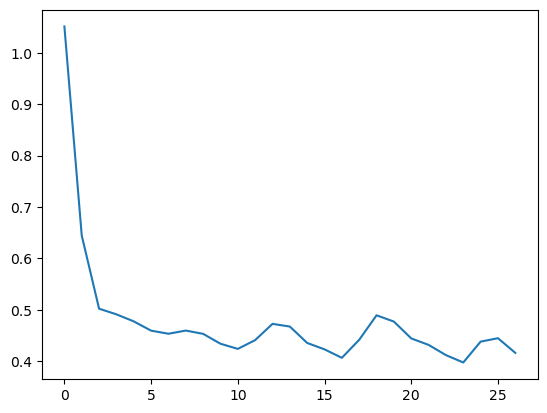

In [24]:
import matplotlib.pyplot as plt

plt.plot(clf.loss_curve_)

## **Cross Validation**

In [25]:
## Cross Validation to check performance ability

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

kf = KFold(n_splits=7,shuffle=False)

accuracies = []

label = y

for iteration, data in enumerate(kf.split(train_tfidf), start=1):

    data_train   = train_tfidf[data[0]]
    target_train = label[data[0]]

    data_test    = train_tfidf[data[1]]
    target_test  = label[data[1]]

    clf = MLPClassifier()
    clf = MLPClassifier(activation= 'relu',solver = 'adam',hidden_layer_sizes=(30,),max_iter = 100, alpha = 0.008, verbose = False, epsilon = 1e-5, random_state = 123, learning_rate_init= 0.1,early_stopping=True, warm_start = True)

    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)

    # for the current fold only
    accuracy = accuracy_score(target_test,preds)

    print("Training ke-", iteration)
    print(classification_report(target_test,preds, zero_division=0.0))
    print("Accuracy ==> ",accuracy_score(target_test, preds))
    print("======================================================")

    # plt.plot(clf.loss_curve_)
    # plt.show()
    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

Training ke- 1
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       480
           1       0.75      0.64      0.69       166
           2       0.91      0.91      0.91       926

   micro avg       0.86      0.85      0.85      1572
   macro avg       0.82      0.78      0.80      1572
weighted avg       0.86      0.85      0.85      1572
 samples avg       0.84      0.85      0.84      1572

Accuracy ==>  0.8403307888040712
Training ke- 2
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       489
           1       0.71      0.63      0.67       153
           2       0.90      0.90      0.90       930

   micro avg       0.85      0.83      0.84      1572
   macro avg       0.80      0.76      0.78      1572
weighted avg       0.84      0.83      0.84      1572
 samples avg       0.83      0.83      0.83      1572

Accuracy ==>  0.8231552162849872
Training ke- 3
              preci

## **Saved Model with Pickle**

In [26]:
## Save Model

with open('model_MLP.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("model_MLP Saved!")

model_MLP Saved!


## **Testing Model**

In [27]:
## Testinng Text

def predict_sentiment(text):
  text = regex_cleansing(text)
  preproces = [preprocesing(text)]
 # print(preproces)
  text_transform = tfidf.transform(preproces)
 # print(text_transform)
  predict = clf.predict(text_transform)
#  print(predict)
  for i in predict:
    if i[0] == 1:
      output = 'Negative'
    elif i[1] == 1:
      output = 'Neutral'
    elif i[2] == 1:
      output = 'Positive'
    ## Condition : [[0 0 0]]
    else:
      output = 'Neutral'
  return output

In [28]:
# Text 1
text = 'Makanan ini sangat enak sekali !!!'

sentiment = predict_sentiment(text)
print(text)
print("Sentiment ==> ",sentiment)

Makanan ini sangat enak sekali !!!
Sentiment ==>  Positive


In [29]:
## Text 2

text = 'Aku Cinta Kamu Dan Dia !!1'

sentiment = predict_sentiment(text)
print(text)
print("Sentiment ==>", sentiment)

Aku Cinta Kamu Dan Dia !!1
Sentiment ==> Positive


In [31]:
## Test Model using data test(Tweet data test)

tweet_df = pd.read_csv('File_Tweet.csv', encoding = 'windows-1250', usecols = [0])
tweet_df.drop_duplicates()

#tweet_df['Tweet_Cleansing'] = tweet_df['Tweet'].apply(regex_cleansing)
#tweet_df['Tweet_Preprocessing'] = tweet_df['Tweet_Cleansing'].apply(preprocesing)

,Tweet
0,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4,USER USER Kaum cebong kapir udah keliatan dong...
...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...
13165,USER Kasur mana enak kunyuk'
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...
13167,USER USER USER USER Bom yang real mudah terdet...


In [32]:
## Predict Tweet Sentiment

tweet_df['Sentiment'] = tweet_df['Tweet'].apply(predict_sentiment)

In [33]:
tweet_df[tweet_df['Sentiment'] == 'Negative']

,Tweet,Sentiment
0,- disaat semua cowok berusaha melacak perhatia...,Negative
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",Negative
4,USER USER Kaum cebong kapir udah keliatan dong...,Negative
5,USER Ya bani taplak dkk \xf0\x9f\x98\x84\xf0\x...,Negative
7,Gue baru aja kelar re-watch Aldnoah Zero!!! pa...,Negative
...,...,...
13163,"Orang Yahudi, Kristen dan Muslim yang belum pe...",Negative
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,Negative
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,Negative
13167,USER USER USER USER Bom yang real mudah terdet...,Negative


In [34]:
tweet_df[tweet_df['Sentiment'] == 'Positive']

,Tweet,Sentiment
1,RT USER: USER siapa yang telat ngasih tau elu?...,Positive
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,Positive
8,Nah admin belanja satu lagi port terbaik nak m...,Positive
9,USER Enak lg klo smbil ngewe',Positive
33,"RT USER: Kelakuan homok jaman now, ngentot aja...",Positive
...,...,...
13117,"USER ngeri banget itu, ati ati nek, berdoa sem...",Positive
13121,Impian warga Indonesia adalah menguasai hartan...,Positive
13149,RT USER: Foto ke 3:\n\nPohon tempat koloni mon...,Positive
13160,[NOSTALGIA DENGAN BUDAYA]; ; nosÂ·talÂ·gia n k...,Positive


In [35]:
tweet_df[tweet_df['Sentiment'] == 'Neutral']

,Tweet,Sentiment
6,deklarasi pilkada 2018 aman dan anti hoax warg...,Neutral
18,Jadi cowo itu harus Gantle kalo ga Gantle itu ...,Neutral
19,USER Slga mnr bom \xf0\x9f\x98\x82',Neutral
22,USER Joko Widodo dinilai sebagai presiden terl...,Neutral
23,PELAJAR SMA KEC BILAH HILIR DEKLARASI ANTI HOA...,Neutral
...,...,...
13147,"USER Memang nggak kasihan ya, paling pasukan n...",Neutral
13150,USER Tambahan : \nArsitektur Universitas Katol...,Neutral
13153,"wilujeng beurang.. ; Dan siapapun kita, latar ...",Neutral
13156,Presiden Joko Widodo (Jokowi) masuk daftar The...,Neutral
